# Data Sience course final project

## Topic : Finding an optimal model reflecting the course of power demand in the KSEE under the normal operation 


#### For this purpose, we will use daily and hourly dataset for a period of 1 month (July 2022)
#### data source : www.pse.pl (daily reports of working KSEE)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

### import dataset from .csv

In [2]:
URL = 'InputData/data_actual_total_load_less.csv'

In [3]:
df = pd.read_csv(URL, sep = ';')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Actual Total Load  744 non-null    object
 1   Date               744 non-null    int64 
 2   Hour               744 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 17.6+ KB


#### Comment :
The raw data consists of 3 columns, of which the column 'actual total load' is of type 'object' - we need to convert it to type 'float'. In addition, we will create a new column 'DateTime', which will be a combination of columns 'date' and 'hour' and converted to type 'datetime64'. We don't have anu null values - so We don't need to fill-in empty empty cells.

In [5]:
df['DateTime'] = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [6]:
df['DateTime'] = df['DateTime'] + pd.to_timedelta(df['Hour'], unit='h')

In [7]:
df['Actual Total Load'] = df['Actual Total Load'].str.replace(',', '.').astype(float)


In [8]:
df.drop(['Date'], axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Actual Total Load  744 non-null    float64       
 1   Hour               744 non-null    int64         
 2   DateTime           744 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 17.6 KB


### Creatin new columns for train/test values for KNN, Decision Tree, XGBoost, LSTM

In [10]:
features = ["year", "month", "day"]

In [11]:
df[features] = df.apply(lambda row: pd.Series({"year":row.DateTime.year, "month":row.DateTime.month, "day":row.DateTime.day}), axis=1)

In [12]:
df2 = df[["Actual Total Load","DateTime"]]

In [13]:
df2.set_index(["DateTime"], inplace = True)

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2022-07-01 01:00:00 to 2022-08-01 00:00:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Actual Total Load  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


### Split data into train-test

In [15]:

end_train = 575

# 'X' only for SARIMAX model
X = df['DateTime']
# 'x' for the rest alghoritms
x = df[["year", "month", "day","Hour"]]
Y = df['Actual Total Load']

X_train = X.iloc[:end_train]
X_test  = X.iloc[end_train:]
x_train = x.iloc[:end_train]
x_test  = x.iloc[end_train:]

Y_train = Y.iloc[:end_train]
Y_test  = Y.iloc[end_train:]

print(f"Train dates      : {df['DateTime'][0]} --- {df['DateTime'][end_train]}  (n={len(X_train)})")
print(f"Test dates       : {df['DateTime'][end_train+1]} --- {df['DateTime'][df['DateTime'].index.max()]}  (n={len(X_test)})")

Train dates      : 2022-07-01 01:00:00 --- 2022-07-25 00:00:00  (n=575)
Test dates       : 2022-07-25 01:00:00 --- 2022-08-01 00:00:00  (n=169)


In [16]:
# Chcecking sum of DataFrames :  train-test
# ==============================================================================

if len(df)==len(Y_train+Y_test):
    print('train + test   = df  (test ok)')
else :
    print('some datas are missing')       

train + test   = df  (test ok)


In [17]:
# proportion of train/test [%]
# ==============================================================================
round(len(Y_train)/len(df)*100,1)

77.3

### Dataset visualisation 

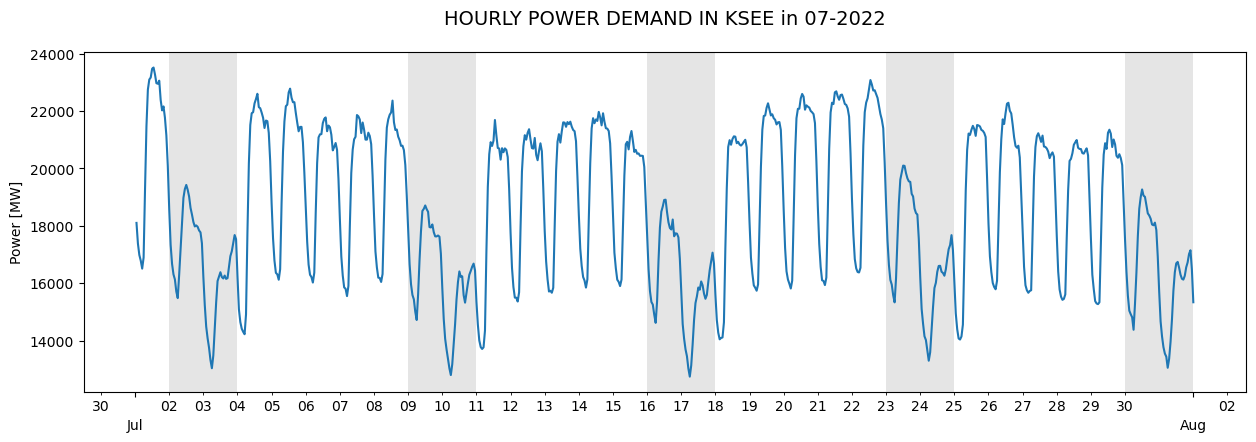

In [18]:
ax = df2.plot(x_compat=True, figsize=(15, 5), legend=None, ylabel='Power [MW]',xlabel = '')
ax.set_ylim(*ax.get_ylim())
xmin, xmax = ax.get_xlim()
days = np.arange(np.floor(xmin), np.ceil(xmax)+2)
weekends = [(dt.weekday()>=5)|(dt.weekday()==0) for dt in mdates.num2date(days)]
ax.fill_between(days, *ax.get_ylim(), where=weekends, facecolor='k', alpha=.1)
ax.set_xlim(xmin, xmax)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=np.arange(1, 31, step=1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%b'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
ax.figure.autofmt_xdate(rotation=0, ha='center')
title = 'HOURLY POWER DEMAND IN KSEE in 07-2022'
ax.set_title(title, pad=20, fontsize=14);

### SARIMAX model

#### We will examine the stationarity feature of the time series according to the Dickey-Fuller method 
hypothesis 𝐻0 : no stationarity

hypothesis 𝐻1 : there is stationarity

if pvalue > 0.05 we accept the hypothesis H0, we reject H1

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
pvalue = adfuller(df2['Actual Total Load'])[1]

In [21]:
if pvalue > 0.05 :
    print('pvalue :  ' + str(pvalue)  +' - We accept the hypothesis H0, reject H1 - the series is non-stationary')
else :
    print('pvalue : ' + str(pvalue)  +' - We accept the hypothesis H1, reject H0 - the series is stationary')


pvalue :  0.4016928841682644 - We accept the hypothesis H0, reject H1 - the series is non-stationary


#### Decomposition od dataset

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df2['Actual Total Load'], model='additive')
trend_estimate = decomposition.trend
seasonal_estimate = decomposition.seasonal
residual_estimate = decomposition.resid

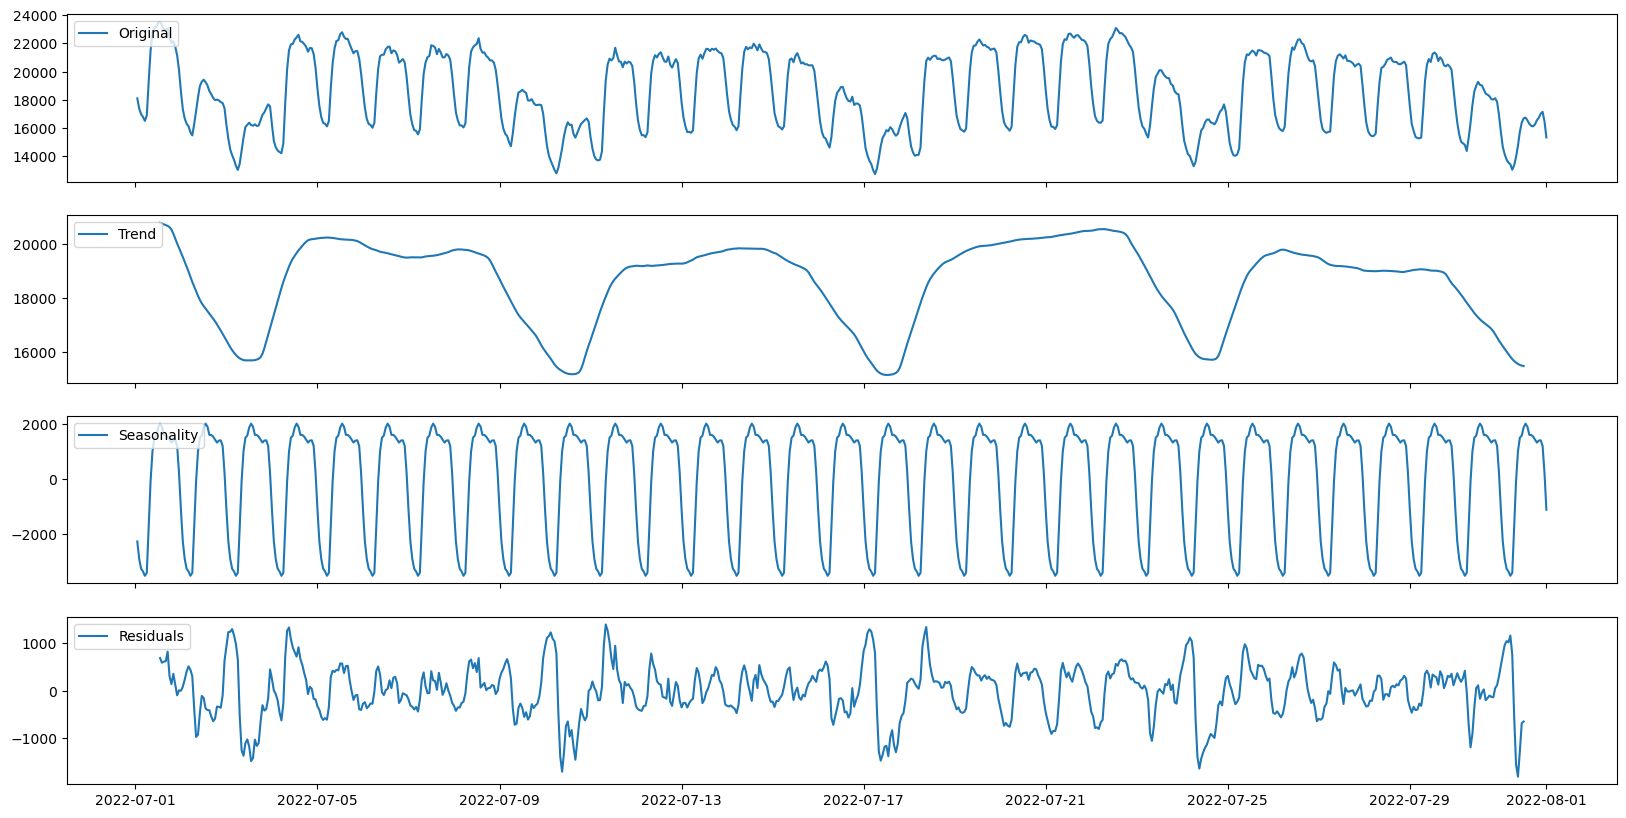

In [23]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20, 10))

axes[0].plot(df2['Actual Total Load'], label='Original') 
axes[0].legend(loc='upper left');

axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');

#### Comment :
We can see clearly seasional nature of the data. The trend is steady. The residiuals aren't so large (+- 1000 MW).

The presented hourly model of power demand in the KSEE is characterized by non-stationarity resulting from the due to the pronounced seasonality of the data (power demand increases in the morning hours and decreases in the evening hours). It follows that the desired model reflecting the operating cycle of the KSEE will be a data model that takes into account  the seasonal factor (SARIMAX)

In [24]:
from pmdarima.arima import auto_arima

In [25]:
SARIMAX_model = auto_arima(y=Y_train,
                           exogenous=X,
                           m=24,
                           max_order=None,
                           max_p=12,
                           max_q=12,
                           max_d=2,
                           max_P=4,
                           max_Q=4,
                           max_D=2,
                           maxiter=100,
                           trace=True,
                           seasonal=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=8211.143, Time=6.96 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=10741.152, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=26.77 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=12955.427, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=8457.890, Time=2.31 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=8341.261, Time=4.17 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=80.24 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=8336.201, Time=64.46 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=8658.884, Time=1.08 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=8392.116, Time=14.14 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=8326.426, Time=52.74 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=77.50 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=7.74 sec
 ARIMA(2,0,1)(1,0,1)[24] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  575
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood               -4097.571
Date:                              Sat, 29 Jul 2023   AIC                           8211.143
Time:                                      15:57:50   BIC                           8245.978
Sample:                                           0   HQIC                          8224.729
                                              - 575                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    153.5984     46.741      3.286      0.001      61.987     245.209
ar.L1          0.3157      0.105      2.994      0.003       0.109       0.522
ar.L2          0.5911      0.103      5.749      0.000       0.390       0.793
ma.L1          1.2197      0.097     12.577      0.000       1.030       1.410
ma.L2          0.5013      0.046     10.913      0.000       0.411       0.591
ar.S.L24       0.9061      0.011     81.117      0.000       0.884       0.928
ma.S.L24      -0.4763      0.026    -18.429      0.000      -0.527      -0.426
sigma2      7.862e+04   3013.285     26.090      0.000    7.27e+04    8.45e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.90   Jarque-Bera (JB):               922.26
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
SARIMAX_model.order

(2, 0, 2)

In [27]:
SARIMAX_model.seasonal_order

(1, 0, 1, 24)

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
sarimax_model = SARIMAX(Y_train, order=SARIMAX_model.order, seasonal_order=SARIMAX_model.seasonal_order, enforce_stationarity=False)
# sarimax_model = SARIMAX(Y_train, order=(2, 0, 2), seasonal_order=(1, 0, 1, 24),)

fitted_model_sarimax = sarimax_model.fit()

pred_sarimax = fitted_model_sarimax.predict(len(Y_train), len(Y_train) + len(Y_test)-1)


C:\Users\pawel\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### GridSearch for KNN

In [30]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [31]:
parameters_KNN = {
    'n_neighbors': [1, 2, 3, 5, 10, 15, 20], 
    'metric': ['minkowski', 'cosine','manhattan','cityblock','l1','l2'], 
    'p': [1, 2]
                }

In [32]:
knn = neighbors.KNeighborsRegressor()
knn_model = GridSearchCV(estimator=knn, 
                   param_grid=parameters_KNN, 
                   cv=5)
knn_model.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['minkowski', 'cosine', 'manhattan',
                                    'cityblock', 'l1', 'l2'],
                         'n_neighbors': [1, 2, 3, 5, 10, 15, 20], 'p': [1, 2]})

In [33]:
knn_model.best_estimator_

KNeighborsRegressor(n_neighbors=15, p=1)

In [34]:
pred_KNN = knn_model.predict(x_test)

### GridSearch for Decision Tree

In [35]:
from sklearn.tree import DecisionTreeRegressor

In [36]:
parameters_dt = {
              "criterion": ['friedman_mse', 'squared_error', 'poisson'],
              "min_samples_split": [2, 3, 5, 10, 20, 40],
              "max_depth": [2, 6, 8, 10, 12],
              "min_samples_leaf": [10, 20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

In [37]:
dtr = DecisionTreeRegressor()
dt_model = GridSearchCV(estimator=dtr, 
                   param_grid=parameters_dt, 
                   cv=5,)

dt_model.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['friedman_mse', 'squared_error',
                                       'poisson'],
                         'max_depth': [2, 6, 8, 10, 12],
                         'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [10, 20, 40, 100],
                         'min_samples_split': [2, 3, 5, 10, 20, 40]})

In [38]:
dt_model.best_estimator_

DecisionTreeRegressor(max_depth=2, max_leaf_nodes=100, min_samples_leaf=10,
                      min_samples_split=3)

In [39]:
pred_dt = dt_model.predict(x_test)

### GridSearch for XGBoost

In [40]:
from xgboost import XGBRegressor

In [41]:
parameters_xgb = {
        'learning_rate': [0.001, 0.01, 0.1],   
        'max_depth': [3, 5, 7, 10, 12],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.2, 0.5, 0.7],
        'colsample_bytree': [0.2, 0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

In [42]:
xgb = XGBRegressor()
xgb_model = GridSearchCV(estimator=xgb, 
                   param_grid=parameters_xgb, 
                   cv=5,)

xgb_model.fit(x_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.2, 0.5, 0.7],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7, 10, 12],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 500],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.2, 0.5, 0.7]})

In [43]:
xgb_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.2, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [44]:
pred_xgb = xgb_model.predict(x_test)

### GridSearch for RandomForest

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
parameters_rf = {
              "n_estimators": [10, 50, 100, 300, 500],
              "max_depth": [2, 5, 10, None]
             }

In [47]:
rf = RandomForestRegressor()
rf_model = GridSearchCV(estimator=rf, 
                   param_grid=parameters_rf, 
                   cv=5,)

rf_model.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5, 10, None],
                         'n_estimators': [10, 50, 100, 300, 500]})

In [48]:
rf_model.best_estimator_

RandomForestRegressor(max_depth=2)

In [49]:
pred_rf = rf_model.predict(x_test)

### LSTM

In [50]:
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [197]:
train = df2.iloc[:end_train]
test = df2.iloc[end_train:]

In [198]:
scaler = MinMaxScaler()

In [199]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#### Define generator of data

In [332]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=10)
X,y = generator[0]

#### Define model

In [362]:
model = Sequential()
model.add(LSTM(100, activation='selu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [363]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 100)               40800     
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


#### model fit

In [364]:
model.fit(generator,epochs=100)

Epoch 1/100
56/56 [==============================] - 1s 7ms/step - loss: 0.0668
Epoch 2/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 3/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 4/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0157
Epoch 5/100
56/56 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 6/100
56/56 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 7/100
56/56 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 8/100
56/56 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 9/100
56/56 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 10/100
56/56 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 11/100
56/56 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 12/100
56/56 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 13/100
56/56 [=================

56/56 [==============================] - 0s 8ms/step - loss: 4.7769e-04
Epoch 100/100
56/56 [==============================] - 0s 8ms/step - loss: 3.9934e-04


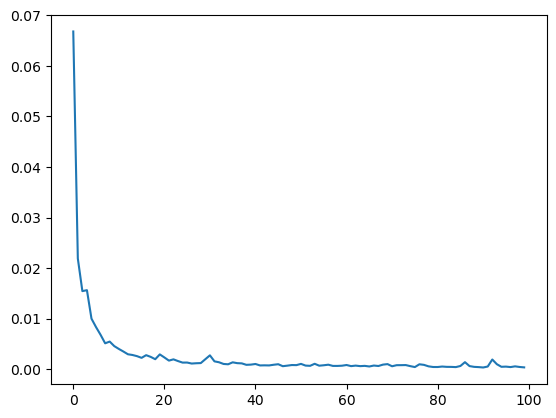

In [365]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [366]:
last_train_batch = scaled_train[-n_input:]

In [367]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [368]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 143ms/step


array([[0.3090633]], dtype=float32)

In [369]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 9ms/step


In [370]:
pred_LSTM = scaler.inverse_transform(test_predictions)

### Models visualisation

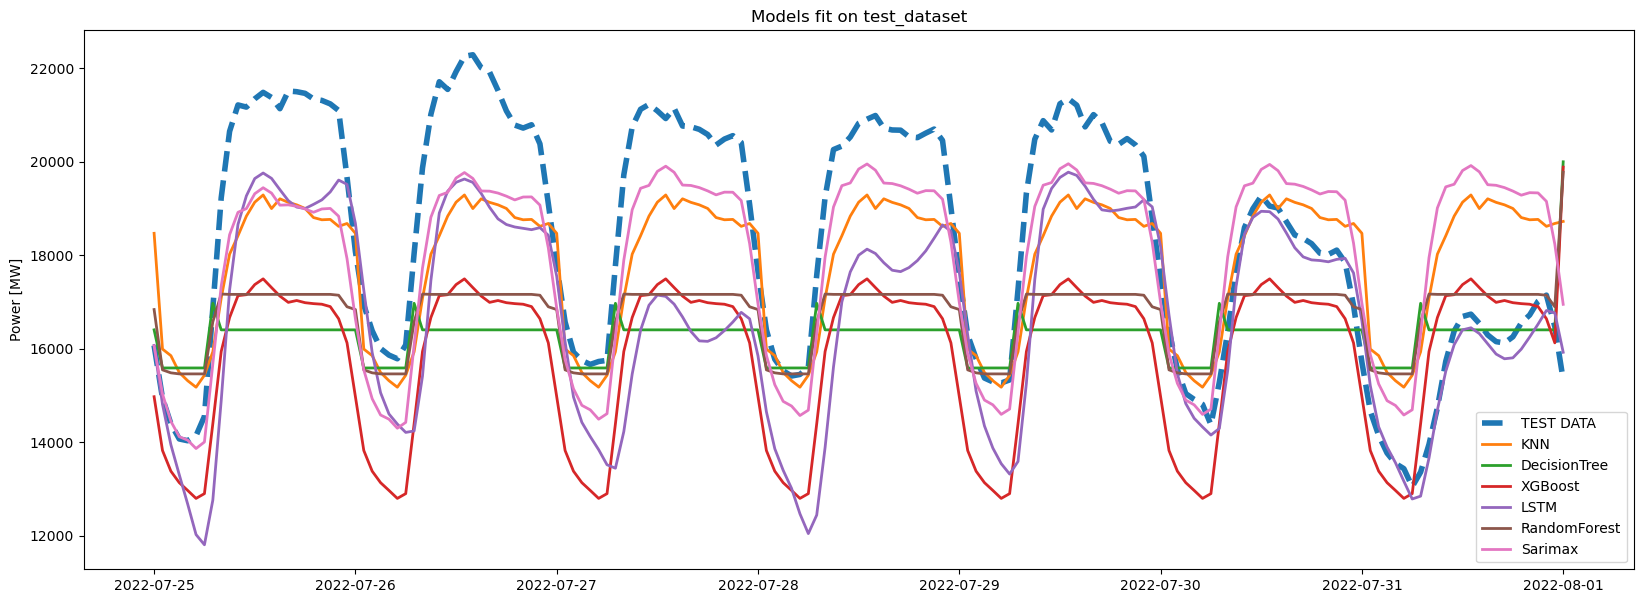

In [371]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(df['DateTime'][end_train:],Y_test, label='TEST DATA', linewidth=4, linestyle='dashed')
plt.plot(df['DateTime'][end_train:],pred_KNN, label='KNN', linewidth=2)
plt.plot(df['DateTime'][end_train:],pred_dt, label='DecisionTree', linewidth=2)
plt.plot(df['DateTime'][end_train:],pred_xgb, label='XGBoost', linewidth=2)
plt.plot(df['DateTime'][end_train:],pred_LSTM, label='LSTM', linewidth=2)
plt.plot(df['DateTime'][end_train:],pred_rf, label='RandomForest', linewidth=2)
plt.plot(df['DateTime'][end_train:],pred_sarimax, label='Sarimax', linewidth=2)
plt.title('Models fit on test_dataset')
plt.legend();
plt.ylabel('Power [MW]');

### Error metrics

In [372]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [373]:
Sarimax_ = round(mean_absolute_percentage_error(Y_test, pred_sarimax)*100,2)

In [374]:
DecissionTree_ = round(mean_absolute_percentage_error(Y_test, pred_dt)*100,2)

In [375]:
KNN_ = round(mean_absolute_percentage_error(Y_test, pred_KNN)*100,2)

In [376]:
XGBoost_ = round(mean_absolute_percentage_error(Y_test, pred_xgb)*100,2)

In [377]:
RandomForest_ = round(mean_absolute_percentage_error(Y_test, pred_rf)*100,2)

In [378]:
LSTM_ = round(mean_absolute_percentage_error(Y_test, pred_LSTM)*100,2)

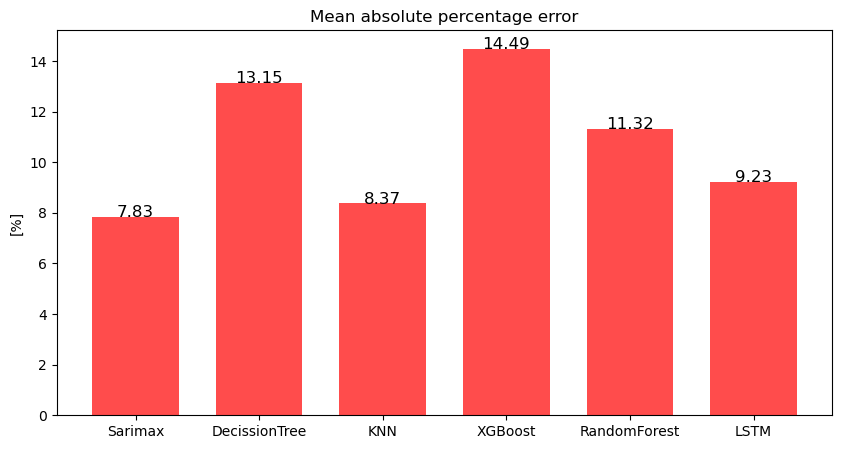

In [379]:
data = {'Sarimax':Sarimax_, 'DecissionTree':DecissionTree_, 'KNN':KNN_,'XGBoost':XGBoost_, 
        'RandomForest':RandomForest_,'LSTM':LSTM_}
model = list(data.keys())
values = list(data.values())

def addlabels(model,values):
    for i in range(len(model)):
        plt.text(i, values[i], values[i], ha = 'center', size=12)
  
fig = plt.figure(figsize = (10, 5))
plt.bar(model, values, color ='red',width = 0.7, alpha=0.7)
addlabels(model,values)
plt.ylabel("[%]")
plt.title("Mean absolute percentage error")
plt.show()

#### Conclusions :
1. The smallest mean absolut error reached SARIMAX model, second is KNN model,
2. The dataset for the models represent the normalized monthly seasonal cycle of a power demand time series with filtered trend and unified variance - in the aspect of the whole year the graph of power demand will be different (day-off, christmas, emergiences situations, etc),
3. Better optimization of the parameters adopted in the modeling would certainly help to obtain better results of fitting to the test data - this involves more computing power and time for that,
4. More accurate score using LSTM model can be achived using optimalisation for hyperparameters.